## Automatic Number Plate Detection

                        Building model from scratch

### 1. Defining the Question

##### a) Specifying the Question

##### b) Defining the Metric for Success

> The analysis aims to detect the number plates of automobiles and other vehicles in images.

> The success of the project will be measured by the accuracy of the model used to predict number plates.

> We aim to achieve an accuracy of 90%

##### c) Understanding the Context

> Over years, NTSA has put in the effort to try and restore sanity on the Kenyan roads. They have tried working hand in hand with local police to implement traffic rules and regulations in order to try and reduce and probably eradicate the loss of lives caused by fatal accidents on the Kenyan roads. Various offenses are not much complicated to deal with since they can be easily detected without the use of special tools. These offenses include; driving while texting or on a call, picking passengers at undesignated areas, PSV drivers and touts, not wearing appropriate attire and without identification badges, 3rd party insurance cover and general car insurance cover, driving license offenses, unauthorized PSV drivers, and exceeding the recommended speed limit. (‌Marketing, A. (2020, March 19) ). There are other crimes that, even though they are noticed in the event of happening, took a lot of time and resources to deal with such as Hit and Run cases,  car theft, and carjacking.

##### d) Recording the Experimental Design

##### e) Data Relevance

> The data provided for this project is relevant and has been sourced from kaggle.

### 2. Reading the Data

In [2]:
# let's import the neccesary libraries for the projects
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2

#### Number Plate Detection by Finding Contours
> We show the overall implementation of Number Plate Detection using the Contour method.

> The contours are a useful tool for shape analysis and object detection and recognition. Using contour detection, we can detect the borders of objects, and therefore, localize them easily.

In [3]:
# let's mount drive
from google.colab import drive
drive.mount('/content/drive')

# specifying the folder
os.chdir('/content/drive/My Drive/CORE/Neural-Network-Project/Neural-Networks-Project/Number-Plate-Detection')

Mounted at /content/drive


## Load the image
In this step, we load an image that contains a car with its license plate.

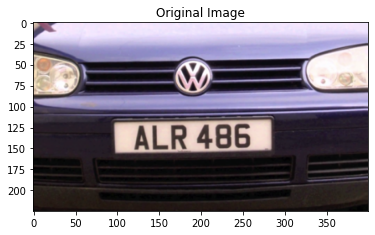

In [4]:
# Read the image file
image = cv2.imread('images/train/Cars14.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

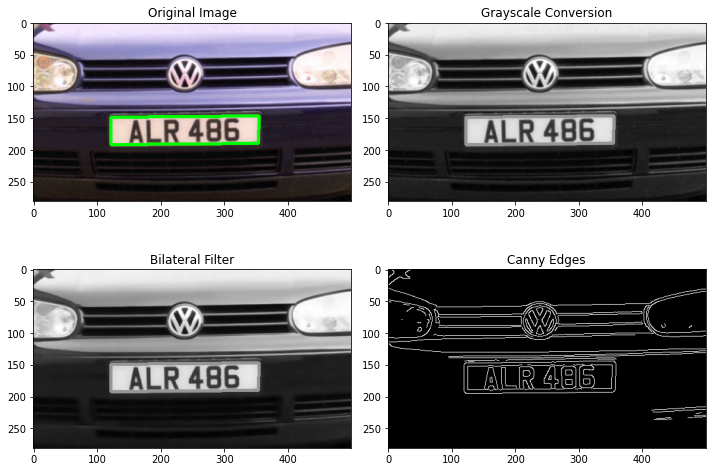

In [6]:
# let's resize the image
image = imutils.resize(image, width=500)
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# let's display the original image
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# let's create a for to loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            break

if NumberPlateCnt is not None:
    # we are drawing the selected contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

## Finding Contours
In this, the image is first preprocessed and then sent for finding contours.
Image preprocessing contains the following steps:
- **Resizing the image**: Each image is resized to 500pixels width, to ease processing in the later stages.
- **Grayscale Conversion**: The input image is in RGB format. Main purpose of this conversion is to reduce the number of colors.
- **Noise Removal**: Image noises are distortion in the image that arises due to fault in camera or result of poor visibility due to changing weather conditions. Noises are also the random variation in the intensity levels of the pixels. Noise can be of various types like Gaussian noise, Salt and pepper noise. We used iterative bilateral filter for noise removal. It provides the mechanism for noise reduction while preserving edges more effectively than median filter.
- **Binarization**: Binarization is the process of converting an image into an image with two pixels value only i.e. containing white and black pixels. Performing binarization process before detecting and extracting license plate from the image will make the task of detecting license plate easier as edges will be more clearly in binary image.

After this, the image is ready to find contours.
Initially, all contours are found by using ```cv2.findContours()``` methods. All the contours with area less than 30 are discarded and the remaining contours are send for further processing. Each contour is approximated to form a polygon and if a contour is quadrilateral in shape (has 4 sides), then it is predicted to be the number plate and the contours are drawn using ```cv2.drawContours()``` method.

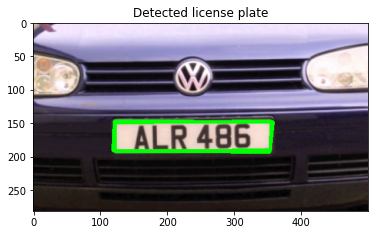

In [7]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected license plate")
plt.show()

The green bounding box shows the detected license plate.

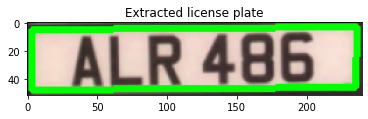

In [8]:
# Find bounding box and extract ROI
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

In [9]:
print(NumberPlateCnt)

[[[358 148]]

 [[121 147]]

 [[119 191]]

 [[353 193]]]


The above displayed coordinates are the coordinates of the detected plate. But the problem is that we don't know which coordinate is where, because contours can start from anywhere randomly and form a continuous path.

Rotation finds the bottom two coordinates. Using these two coordinates, we can easily find the angle of rotation. This will be illustrated shortly.

## Let's Rotate the plate (if tilted)
This step is useful if the extracted license plate is tilted/rotated. It might cause problems in the character segmentation phase, so it is better to straighten it up.

In [10]:
# Distance between (x1, y1) and (x2, y2)
def dist(x1, x2, y1, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

As discussed, we need to find the bottom two coordinates:
- To find them, we'll first find a coordinate with the maximum y-coordinate and this will be one of the two bottom-most coordinates.
- Now, the other bottom coordinate will be either to the left or right of this coordinate in the array. Since, number plates are rectangular in shape, the second required coordinate would be in a distance far away from the acquired coordinate than the other adjacent coordinate.

In [11]:
idx=0
m=0
# let's find the index of coordinate with maximum y-coordinate
for i in range(4):
    if NumberPlateCnt[i][0][1]>m:
        idx=i
        m=NumberPlateCnt[i][0][1]

# let's assign index to the previous coordinate
if idx==0:
    pin=3
else:
    pin=idx-1

# let's assign index to the next coordinate
if idx==3:
    nin=0
else:
    nin=idx+1

# let's find distances between the acquired coordinate and its previous and next coordinate
p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

# The coordinate that has more distance from the acquired coordinate is the required second bottom-most coordinate
if p>n:
    if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
        left=pin
        right=idx
    else:
        left=idx
        right=pin
    d=p
else:
    if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
        left=nin
        right=idx
    else:
        left=idx
        right=nin
    d=n
print(left, right)

2 3


Extract the coordinates of the bottom-most coordinates in such a way that ```(left_x, left_y)``` denote the bottom-left coordinate and ```(right_x, right_y)``` denote the bottom-right coordinate.

In [12]:
left_x=NumberPlateCnt[left][0][0]
left_y=NumberPlateCnt[left][0][1]
right_x=NumberPlateCnt[right][0][0]
right_y=NumberPlateCnt[right][0][1]
print(left_x, left_y, right_x, right_y)

119 191 353 193


For rotating the plate, we need to find the angle of rotation. This can be found out by calculating the sin of theta using the two coordinates. Theta can then be extracted by finding the inverse of sin. Image can finally be rotated by using ```cv2.getRotationMatrix2D()``` function.

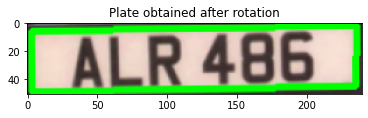

In [13]:
# let's find the angle of rotation by calculating sin of theta
opp=right_y-left_y
hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
sin=opp/hyp
theta=math.asin(sin)*57.2958

# let's rotate the image according to the angle of rotation obtained
image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

# The image can be cropped after rotation( since rotated image takes much more height)
if opp>0:
    h=result.shape[0]-opp//2
else:
    h=result.shape[0]+opp//2

result=result[0:h, :]
plt.imshow(result)
plt.title("Plate obtained after rotation")
plt.show()

## Character Segmentation
Character segmentation is an operation that decomposes an image of a sequence of characters into subimages of individual symbols. It is one of the decision processes in a system for Optical Character Recognition (OCR).

This phase contains the use of two functions: ```segment_characters()``` and ```find_contours()``` functions.

In [14]:
# let's match contours to number plate or character template
def find_contours(dimensions, img) :

    # let's find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # let's retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # let's check largest 5 or 15 contours for number plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # let's detect contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # let's check the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # let's extract each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # let's make a result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # let's resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # let's return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In the above function, we will be applying some more image processing to extract the individual characters from the number plate. The steps involved will be:
- Finding all the contours in the input image. The function cv2.findContours returns all the contours it finds in the image.
- After finding all the contours we consider them one by one and calculate the dimension of their respective bounding rectangle. Now consider bounding rectangle is the smallest rectangle possible that contains the contour. All we need to do is do some parameter tuning and filter out the required rectangle containing required characters. For this, we will be performing some dimension comparison by accepting only those rectangle that have:
  1. Width in the range 0, (length of the pic)/(number of characters) and,
  2. Length in a range of (width of the pic)/2, 4*(width of the pic)/5. After this step, we should have all the characters extracted as binary images.

In [15]:
# let's find characters in the resulting images
def segment_characters(image) :

    # let's preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # let's make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # let's set contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

The above function takes in the image as input and performs the following operations on it:
- Resizes it to a dimension such that all characters seem distinct and clear.
- Convert the colored image to a gray scaled image. We do this to prepare the image for the next process.
- Now the threshold function converts the grey scaled image to a binary image i.e each pixel will now have a value of 0 or 1 where 0 corresponds to black and 1 corresponds to white. It is done by applying a threshold that has a value between 0 and 255, here the value is 200 which means in the grayscaled image for pixels having a value above 200, in the new binary image that pixel will be given a value of 1. And for pixels having value below 200, in the new binary image that pixel will be given a value of 0.
- The image is now in binary form and ready for the next process Eroding. Eroding is a simple process used for removing unwanted pixels from the object’s boundary meaning pixels that should have a value of 0 but are having a value of 1.
- The image is now clean and free of boundary noise, we will now dilate the image to fill up the absent pixels meaning pixels that should have a value of 1 but are having value 0.
- The next step now is to make the boundaries of the image white. This is to remove any out of the frame pixel in case it is present.
- Next, we define a list of dimensions that contains 4 values with which we’ll be comparing the character’s dimensions for filtering out the required characters.
- Through the above processes, we have reduced our image to a processed binary image and we are ready to pass this image for character extraction.

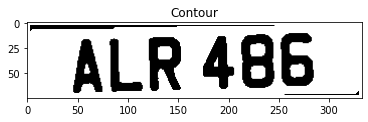

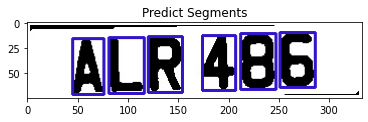

In [16]:
char=segment_characters(result)

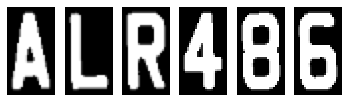

In [17]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## Character Recognition using Convolutional Neural Networks
Since the data is all clean and ready, now it’s time do create a Neural Network that will be intelligent enough to recognize the characters after training. In this project, we used CNN model for character recognition.
- For training the model, we’ll be using ImageDataGenerator class available in keras to generate some more data using image augmentation techniques like width shift, height shift.
- Width shift: Accepts a float value denoting by what fraction the image will be shifted left and right.
- Height shift: Accepts a float value denoting by what fraction the image will be shifted up and down.

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


For the model, we'll use 4 convolutional layers with a Max pooling layer of window size = (4,4). We'll also use 2 Dense layers where the last dense layers will have 36 output units (26 alphabets + 10 digits) and the activation function used will be 'softmax' because this is a multi-classification problem.

The below parameters used in the model have already been optimized using hyperparamter tuning.

In [19]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

We'll now go ahead and test our model. Note that the attribute ```steps_per_epoch``` is set to be ```train_generator.samples // batch_size``` because it ensures the usage of all the train data for one epoch.

In [21]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
864/864 [==============================] - 293s 337ms/step - loss: 3.1143 - accuracy: 0.1285 - val_loss: 1.9744 - val_accuracy: 0.5000
Epoch 2/25
864/864 [==============================] - 75s 87ms/step - loss: 1.4108 - accuracy: 0.5729 - val_loss: 1.2391 - val_accuracy: 0.6574
Epoch 3/25
864/864 [==============================] - 76s 88ms/step - loss: 0.6981 - accuracy: 0.7824 - val_loss: 0.4309 - val_accuracy: 0.8426
Epoch 4/25
864/864 [==============================] - 76s 88ms/step - loss: 0.4519 - accuracy: 0.8576 - val_loss: 0.2884 - val_accuracy: 0.9074
Epoch 5/25
864/864 [==============================] - 74s 86ms/step - loss: 0.3168 - accuracy: 0.9074 - val_loss: 0.2647 - val_accuracy: 0.9167
Epoch 6/25
864/864 [==============================] - 74s 85ms/step - loss: 0.2955 - accuracy: 0.8993 - val_loss: 0.1649 - val_accuracy: 0.9537
Epoch 7/25
864/864 [==============================] - 73s 85ms/step - loss: 0.1939 - accuracy: 0.9410 - val_loss: 0.1089 - val_accurac

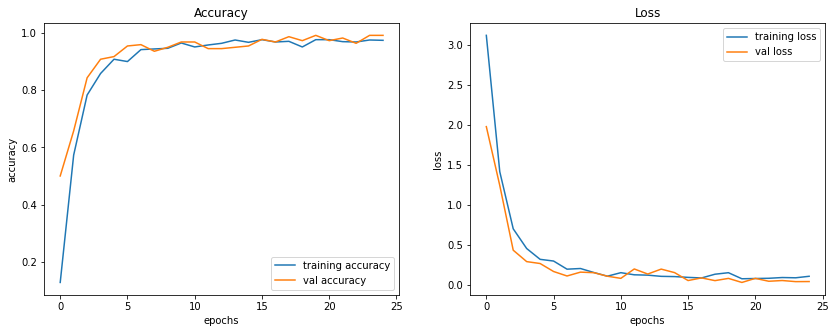

In [22]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Save the model weights for future use.

In [23]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

Since we saved only the model weights, we first need to create a model instance and then load the saved weights into the model.

In [32]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

## Predict the license plate number
We now have our license plate and the CNN model ready! We just need to predict each character using the model. For this, we'll first fix the dimension of each character image using the function ```fix_dimension```, in which it converts an image to a 3-channel image. The image can then be sent to ```model.predict_classes()``` in order to get the predicted character.

In [34]:
from keras.models import Sequential

# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict_class(img) #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

AttributeError: ignored

In [ ]:
file_list=os.listdir(r"images/Indian-Number-Plates")
count=0
for path in file_list:
    no=path[:-4]
    #row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    image = cv2.imread('images/Indian-Number-Plates/'+path)
    # Resize the image - change width to 500
    image = imutils.resize(image, width=500)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)

    # Find contours based on Edges
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None #we currently have no Number plate contour

    # loop over our contours to find the best possible approximate contour of number plate
    for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:  # Select the contour with 4 corners
                NumberPlateCnt = approx #This is our approx Number Plate Contour
                x,y,w,h = cv2.boundingRect(c)
                ROI = img[y:y+h, x:x+w]
                break

    idx=0
    m=0
    if NumberPlateCnt is None:
        continue
    for i in range(4):
        if NumberPlateCnt[i][0][1]>m:
            idx=i
            m=NumberPlateCnt[i][0][1]
    if idx==0:
        pin=3
    else:
        pin=idx-1
    if idx==3:
        nin=0
    else:
        nin=idx+1

    p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
    n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

    if p>n:
        if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
            left=pin
            right=idx
        else:
            left=idx
            right=pin
        d=p
    else:
        if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
            left=nin
            right=idx
        else:
            left=idx
            right=nin
        d=n
    left_x=NumberPlateCnt[left][0][0]
    left_y=NumberPlateCnt[left][0][1]
    right_x=NumberPlateCnt[right][0][0]
    right_y=NumberPlateCnt[right][0][1]

    opp=right_y-left_y
    hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
    sin=opp/hyp
    theta=math.asin(sin)*57.2958

    image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

    if opp>0:
        h=result.shape[0]-opp // 2
    else:
        h=result.shape[0]+opp // 2

    result=result[0:h, :]
    char=segment_characters(result)
    count=show_results(count)
print("Accuracy: " + str((count/166)*100)+"%")

AttributeError: ignored

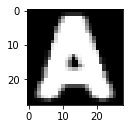

In [141]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Importing the dataset
We'll now import our dataset to calculate the overall accuracy of this method. The dataset contains about 200 images with a labels.xlsx that will be useful to check if the predicted output is correct

In [ ]:
labels=pd.read_excel('test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

,ID,NUMBER
0,1,KL55R2473
1,2,GJW115A1138
2,3,KL16J3636
3,4,MH20EE7598
4,5,PJJ1L76
...,...,...
181,182,DHF5B15
182,183,DBJ5R59
183,184,LVY8X45
184,185,YYD6B61


## Accuracy
We now need to run the whole code for all the images and calculate the accuracy.

In [ ]:
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # iterating over the characters
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        y_ = loaded_model.predict_classes(img)[0]  # predicting the class
        character = dic[y_]
        output.append(character)  # storing the result in a list

    plate_number = ''.join(output)

    return plate_number


print(show_results())

# let's rewrite the above code in a more concise way
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # iterating over the characters
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        y_ = loaded_model.predict(img)[0],[1]  # predicting the class
        character = dic[y_]
        output.append(character)  # storing the result in a list

    plate_number = ''.join(output)

    return plate_number


Accuracy: 60.24096385542169%


In [ ]:
if opp > 0:
        h = result.shape[0]-opp//2
    else:
        h=result.shape[0]+opp//2

    result=result[0:h, :]
    char=segment_characters(result)
    count=show_results(count)
print("Accuracy: "+str((count/166)*100)+"%")